# Project 3

- Mateusz Bernart, 156072

---

## Data

Used datasets:
- https://www.kaggle.com/datasets/thedownhill/art-images-drawings-painting-sculpture-engraving/data - Iconography (old Russian art)
- https://zenodo.org/records/4737435 - extension to provide some data diversity

---
## Problem

Problem:
- Iconography colorization using neural networks

---

#### General concept of neural network

- U-net-inspired network with VGG16

#### Points

|Category| What | Points |
|-|-|-|
|Problem|Colorization|1|
|Model|transfer-learning|1|
|Training|Testing various loss functions|1|
|Training|Hyperparameter tuning or estimation|1|
|Training|Testing a few optimizers|1|
|Sum||5|


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import cv2
from skimage import color
from keras import regularizers
from tensorflow.keras.losses import MeanSquaredError
from skimage.metrics import structural_similarity as ssim_metric
import os
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
from skimage.color import lab2rgb, rgb2lab
from keras.saving import load_model
import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, initializers
from keras.callbacks import ReduceLROnPlateau


In [ ]:
MODEL_FILE = "colorizer.keras"


In [ ]:
class ArtDataGenerator(Sequence):
    def __init__(self, image_paths, batch_size=32, img_size=(256, 256)):
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.img_size = img_size
        self.indices = np.arange(len(self.image_paths))

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index *
                                     self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.image_paths[i] for i in batch_indices]
        L_batch, ab_batch = self.__data_generation(batch_images)
        return L_batch, ab_batch

    def __data_generation(self, batch_images):
        L_batch = []
        ab_batch = []

        for image_path in batch_images:
            img = cv2.imread(image_path)
            if img is None:
                print(f"Image not found: {image_path}")
                continue
            img = rgb2lab(img)
            img = cv2.resize(img, self.img_size)
            img = img.astype('float32')

            L_channel = img[..., 0:1] / 100.0
            ab_channels = img[..., 1:] / 128.0
            L_batch.append(L_channel)
            ab_batch.append(ab_channels)

        L_batch = np.array(L_batch)
        ab_batch = np.array(ab_batch)

        return L_batch, ab_batch

    def on_epoch_end(self):
        np.random.shuffle(self.indices)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -o "/content/drive/MyDrive/PUT/term5/CV/IconArt_v2.zip" -d "/content/" >> /dev/null


In [ ]:
!unzip -o "/content/drive/MyDrive/PUT/term5/CV/musemart.zip" -d "/content/"  >> /dev/null


In [ ]:
!unzip -o "/content/drive/MyDrive/PUT/term5/CV/dataset.zip" -d "/content/" >> /dev/null


In [ ]:
!unzip -o "/content/drive/MyDrive/PUT/term5/CV/archive.zip" -d "/content/" >> /dev/null


In [ ]:
train_paths = ['/content/dataset/dataset_updated/training_set/iconography',
               '/content/musemart/dataset_updated/training_set/iconography',
               '/content/IconArt_v2/JPEGImages'
               ]
val_paths = ['/content/dataset/dataset_updated/validation_set/iconography',
             '/content/musemart/dataset_updated/validation_set/iconography']


In [ ]:
def get_image_paths_recursive(paths, extensions=('jpg', 'jpeg', 'png')):
    image_paths = []
    for path in paths:
        for root, _, files in os.walk(path):
            for file in files:
                if file.lower().endswith(extensions):
                    image_paths.append(os.path.join(root, file))
    return image_paths


In [ ]:
train_image_paths = get_image_paths_recursive(train_paths)
val_image_paths = get_image_paths_recursive(val_paths)


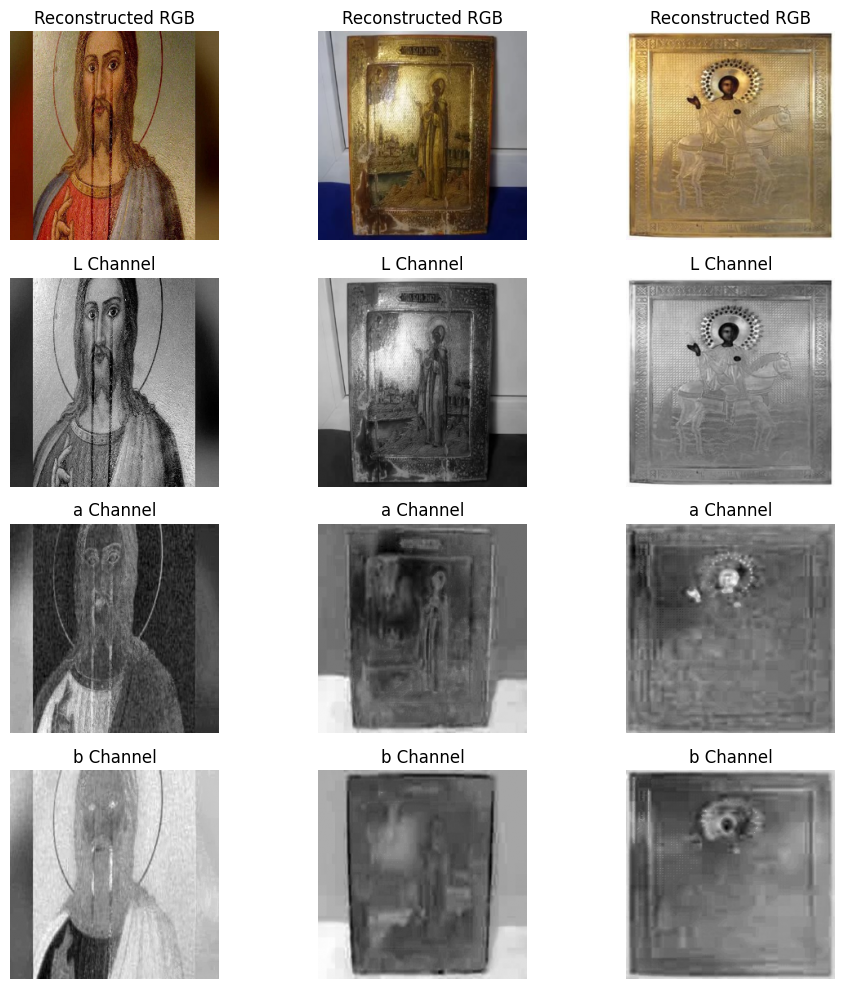

In [ ]:
batch_size = 32
img_size = (256, 256)

train_generator = ArtDataGenerator(
    train_image_paths, batch_size=batch_size, img_size=img_size)
val_generator = ArtDataGenerator(
    val_image_paths, batch_size=batch_size, img_size=img_size)

for L_batch, ab_batch in train_generator:
    batch_size = L_batch.shape[0]
    rgb = np.zeros((batch_size, 256, 256, 3))

    ab_batch = ab_batch * 128.0

    for i in range(batch_size):
        L = L_batch[i] * 100.0
        ab = ab_batch[i]  # Already scaled!!!!
        img_lab = np.concatenate([L, ab], axis=-1)
        img_rgb = lab2rgb(img_lab)
        img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
        rgb[i] = img_rgb

    plt.figure(figsize=(10, 10))
    for i in range(3):
        if i >= batch_size:
            break

        # RGB image
        plt.subplot(4, 3, i + 1)
        plt.imshow(rgb[i])
        plt.axis('off')
        plt.title("Reconstructed RGB")

        # Grayscale L channel
        plt.subplot(4, 3, i + 4)
        plt.imshow(L_batch[i].reshape(256, 256), cmap='gray')
        plt.axis('off')
        plt.title("L Channel")

        # a channel
        plt.subplot(4, 3, i + 7)
        plt.imshow(ab_batch[i, :, :, 0], cmap='gray')
        plt.axis('off')
        plt.title("a Channel")

        # b channel
        plt.subplot(4, 3, i + 10)
        plt.imshow(ab_batch[i, :, :, 1], cmap='gray')
        plt.axis('off')
        plt.title("b Channel")

    plt.tight_layout()
    plt.show()
    break


### Custom Metrics for Model Evaluation
$ $
1. **PSNR (Peak Signal-to-Noise Ratio) Metric**:
   - **Purpose**: Measures the quality of the reconstructed image compared to the ground truth. A higher PSNR value indicates better reconstruction quality.
   - **Implementation**:
     - Uses TensorFlow's `tf.image.psnr` function.
     - `max_val=1.0` assumes normalized input images where pixel values are in the range `[0, 1]`.

2. **SSIM (Structural Similarity Index) Metric**:
   - **Purpose**: Evaluates the similarity between the predicted and ground truth images in terms of luminance, contrast, and structure. A higher SSIM value (closer to 1) indicates higher similarity.
   - **Implementation**:
     - Uses TensorFlow's `tf.image.ssim` function.
     - `max_val=1.0` assumes normalized images with values in `[0, 1]`.

In [ ]:
@keras.saving.register_keras_serializable()
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)


@keras.saving.register_keras_serializable()
def ssim_metric_tf(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)


### Report: Iconography Colorization Neural Network Architecture

#### Overview
The proposed network architecture is a U-Net-inspired model designed for the task of grayscale-to-color image translation, specifically for iconography colorization. The model leverages a pretrained VGG16 network as the encoder, paired with a custom decoder that integrates skip connections and Leaky ReLU activations. The network's primary goal is to predict the `a` and `b` chrominance channels in the LAB color space from a grayscale image (`L` channel).

---

#### **Network Architecture**

1. **Input Layer**:
   - The input to the network is a single-channel grayscale image with a shape of `(256, 256, 1)`.
   - Converted to a three-channel image using a `Conv2D` layer to match the expected input shape of the VGG16 encoder `(256, 256, 3)`.

2. **Encoder**:
   - Based on the pretrained VGG16 network, trained on the ImageNet dataset. This ensures the model can leverage learned hierarchical feature representations.
   - Five feature maps are extracted from the output of VGG16's pooling layers (`block1_pool` through `block5_pool`).
   - The VGG16 layers are frozen to preserve the pretrained weights and reduce amount of computations.

3. **Decoder**:
   - The decoder reconstructs the color information (`a`, `b` channels) from the features extracted by the encoder.
   - **Key Components**:
     - **Skip Connections**: Features from each encoder stage are concatenated with the corresponding decoder stage, enabling the network to retain both low-level and high-level features for accurate color reconstruction.
     - **Leaky ReLU Activations**: These activations introduce non-linearity while addressing potential dead neuron issues during training. Reducing `alpha` parameter from `0.3` to `0.2` resulted in faster convergence and `a*b` colors were more various.
     - **Upsampling Layers**: `UpSampling2D` layers progressively upscale the feature maps to the original resolution.

4. **Output Layer**:
   - The final layer uses a `Conv2D` operation with two filters and linear activation to predict the `a` and `b` chrominance channels in the LAB color space.
   - The output shape is `(256, 256, 2)`.

---

#### **Applications**
This architecture is tailored for colorizing grayscale iconographic images, where the goal is to produce colorizations.

---

#### **Parameters**

Total parameters: 20.2M
- 5.5M trainable,
- 14.7M non-trainable (from VGG16).

Trainable weights are primarily in the decoder, enabling efficient transfer learning.


In [ ]:
def create_model_with_resilient_decoder(input_shape=(256, 256, 1)):
    vgg16_base = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
    vgg16_outputs = [layer.output for layer in vgg16_base.layers if "pool" in layer.name]

    for layer in vgg16_base.layers:
        layer.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(3, (3, 3), activation="linear", padding="same")(inputs)

    vgg16_encoder = models.Model(inputs=vgg16_base.input, outputs=vgg16_outputs)

    enc_features = vgg16_encoder(x)

    x = layers.Conv2D(512, (3, 3), padding="same", kernel_initializer="he_normal")(enc_features[4])
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Concatenate()([x, enc_features[3]])

    x = layers.Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Concatenate()([x, enc_features[2]])

    x = layers.Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Concatenate()([x, enc_features[1]])

    x = layers.Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Concatenate()([x, enc_features[0]])

    x = layers.Conv2D(32, (3, 3), padding="same", kernel_initializer="he_normal")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.UpSampling2D((2, 2))(x)

    outputs = layers.Conv2D(2, (3, 3), activation="linear", padding="same")(x)

    model = models.Model(inputs, outputs)
    return model

model = create_model_with_resilient_decoder()
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 3)    │             30 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ [(None, 128, 128, 64), │     14,714,688 │ conv2d[0][0]           │
│                           │ (None, 64, 64, 128),   │                │                        │
│                           │ (None, 32, 32, 256),   │                │                        │
│                           │ (None, 16, 16, 512),   │                │                        │
│                           │ (None, 8, 8, 512)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 8, 8, 512)      │      2,359,808 │ functional[0][4]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 8, 8, 512)      │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 16, 16, 512)    │              0 │ leaky_re_lu[0][0]      │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 1024)   │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ functional[0][3]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 256)    │      2,359,552 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 16, 16, 256)    │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 32, 32, 256)    │              0 │ leaky_re_lu_1[0][0]    │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 32, 32, 512)    │              0 │ up_sampling2d_1[0][0], │
│ (Concatenate)             │                        │                │ functional[0][2]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 128)    │        589,952 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_2           │ (None, 64, 64, 128)    │              0 │ leaky_re_lu_2[0][0]    │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2        

 Total params: 20,209,024 (77.09 MB)

 Trainable params: 5,494,336 (20.96 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Metrics

1. **Mean Squared Error (MSE)**:  
   Measures the average squared difference between predicted and actual values. Smaller values indicate closer predictions to the ground truth, emphasizing pixel-level accuracy.

2. **PSNR (Peak Signal-to-Noise Ratio)**:  
   Evaluates the quality of the reconstructed image compared to the ground truth. Higher values (in decibels) indicate better reconstruction quality, with less error and noise.

3. **SSIM (Structural Similarity Index)**:  
   Assesses the similarity between predicted and ground truth images, focusing on structural features like luminance, contrast, and texture. Values close to 1 indicate high perceptual similarity.


## Loss function 

Tested:
- **L1** - performed best
- **L2** - depending on architecture resulted in many dead neurons or was biased to blue
- **Huber** - similar problem as with L2 

## Additional tests
- **Random noise** - resulted in many dead neurons in every scenario  

## Optimizer selection 

Tested:
- **Adam**
- **SGD** - performed extremely slow. No resources to work with
- **RMSprop** - performed similar to Adam - provided even faster convergence but the output was was extremely biased - like a brown layer was applied on the image. In `LAB` output a and b had almost no diversity.

![metrics](./training_metrics_first_v2.png "Training metrics")

In [ ]:
model.compile(optimizer='adam', loss="mae",
              metrics=[MeanSquaredError(), psnr_metric, ssim_metric_tf])


In [ ]:
!cp "/content/drive/MyDrive/PUT/term5/CV/colorizer_2.keras" $MODEL_FILE


In [ ]:
model = load_model(MODEL_FILE, safe_mode=False)


In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.001)

history = model.fit(train_generator,
          validation_data=val_generator,
          epochs=10,
          batch_size=64,
          callbacks=[reduce_lr]
          )

# image net statistrict normalization
# losowy szum jako osobny kanał (niewielki)


Epoch 1/10
 67/290 ━━━━━━━━━━━━━━━━━━━━ 7:12 2s/step - loss: 0.4055 - mean_squared_error: 0.3154 - psnr_metric: 6.3070 - ssim_metric_tf: 0.0030Image not found: /content/dataset/dataset_updated/training_set/iconography/331.jpg
 76/290 ━━━━━━━━━━━━━━━━━━━━ 6:46 2s/step - loss: 0.3925 - mean_squared_error: 0.2982 - psnr_metric: 6.6437 - ssim_metric_tf: 0.0034Image not found: /content/dataset/dataset_updated/training_set/iconography/69.jpg
 95/290 ━━━━━━━━━━━━━━━━━━━━ 6:04 2s/step - loss: 0.3695 - mean_squared_error: 0.2690 - psnr_metric: 7.2591 - ssim_metric_tf: 0.0043Image not found: /content/musemart/dataset_updated/training_set/iconography/69.jpg
137/290 ━━━━━━━━━━━━━━━━━━━━ 4:50 2s/step - loss: 0.3371 - mean_squared_error: 0.2275 - psnr_metric: 8.1642 - ssim_metric_tf: 0.0059Image not found: /content/musemart/dataset_updated/training_set/iconography/331.jpg
290/290 ━━━━━━━━━━━━━━━━━━━━ 578s 2s/step - loss: 0.2694 - mean_squared_error: 0.1548 - psnr_metric: 10.5027 - ssim_metric_tf: 0.

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


 97/290 ━━━━━━━━━━━━━━━━━━━━ 5:57 2s/step - loss: 0.0949 - mean_squared_error: 0.0158 - psnr_metric: 18.8854 - ssim_metric_tf: 0.1087Image not found: /content/musemart/dataset_updated/training_set/iconography/69.jpg
122/290 ━━━━━━━━━━━━━━━━━━━━ 5:11 2s/step - loss: 0.0951 - mean_squared_error: 0.0158 - psnr_metric: 18.8683 - ssim_metric_tf: 0.1082Image not found: /content/dataset/dataset_updated/training_set/iconography/331.jpg
132/290 ━━━━━━━━━━━━━━━━━━━━ 4:52 2s/step - loss: 0.0950 - mean_squared_error: 0.0158 - psnr_metric: 18.8731 - ssim_metric_tf: 0.1084Image not found: /content/musemart/dataset_updated/training_set/iconography/331.jpg
144/290 ━━━━━━━━━━━━━━━━━━━━ 4:30 2s/step - loss: 0.0948 - mean_squared_error: 0.0158 - psnr_metric: 18.8855 - ssim_metric_tf: 0.1089Image not found: /content/dataset/dataset_updated/training_set/iconography/69.jpg
290/290 ━━━━━━━━━━━━━━━━━━━━ 564s 2s/step - loss: 0.0920 - mean_squared_error: 0.0152 - psnr_metric: 19.1204 - ssim_metric_tf: 0.1172 - 

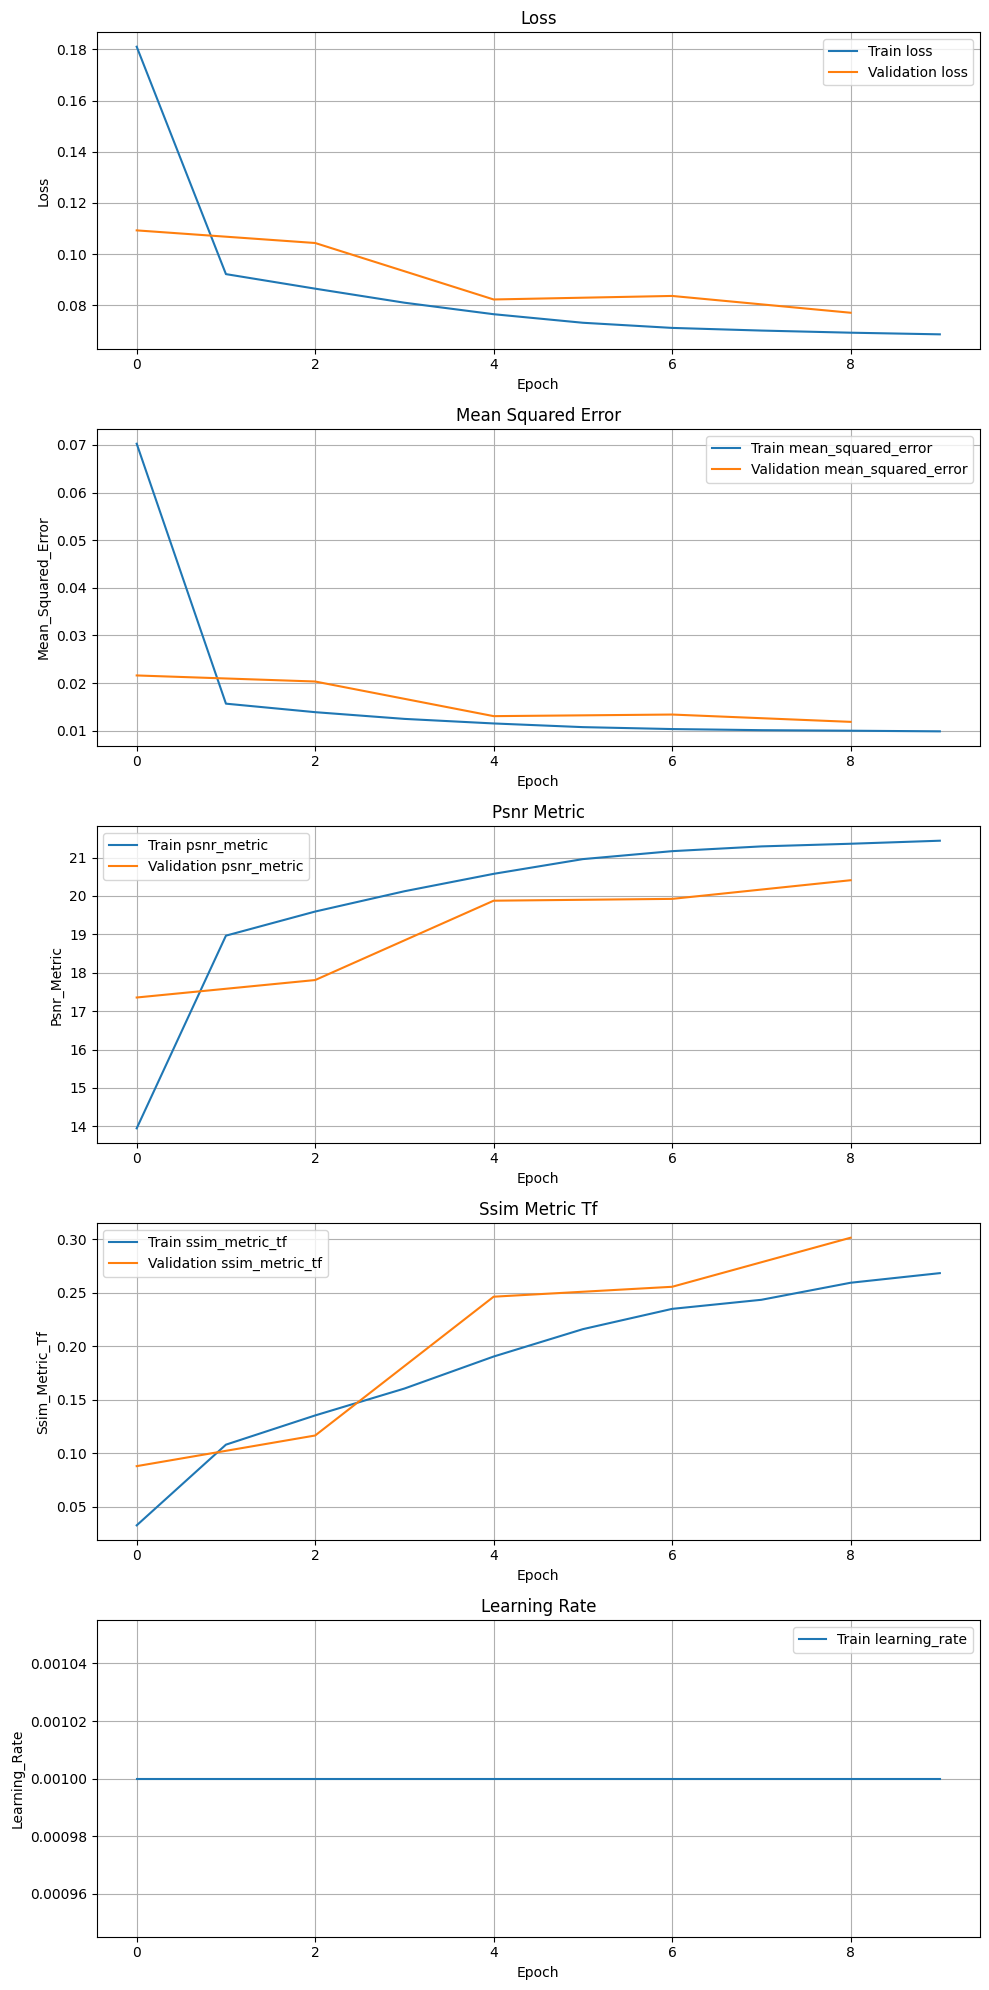

In [ ]:
def plot_history(history):
    train_metrics = {k: v for k, v in history.history.items() if not k.startswith('val_')}

    num_metrics = len(train_metrics)
    plt.figure(figsize=(10, num_metrics * 4))

    for i, (metric, values) in enumerate(train_metrics.items()):
        plt.subplot(num_metrics, 1, i + 1)
        plt.plot(range(len(values)), values, label=f'Train {metric}')

        val_metric = f'val_{metric}'
        if val_metric in history.history:
            plt.plot(history.history[val_metric], label=f'Validation {metric}')


        plt.title(metric.replace("_", " ").title())
        plt.xlabel('Epoch')
        plt.ylabel(metric.title())
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


plot_history(history)


In [ ]:
model.save(MODEL_FILE)


In [ ]:
!cp $MODEL_FILE "/content/drive/MyDrive/PUT/term5/CV/colorizer_2025_01_13.keras"


In [ ]:
import pickle

with open('/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)


!cp "/trainHistoryDict" "/content/drive/MyDrive/PUT/term5/CV/trainHistoryDict_first.pickle"


## Results 

### Qualitative Evaluation
The model successfully preserves the structure and contrast of the original images, though some artifacts and deviations in color intensity are observed. The reconstructed images tend to have a warmer or desaturated tone compared to the target images

#### LAB Channel Analysis
- L Channel - luminance perfectly matched
- a and b Channels - color channels exhibit some loss of fine details and color intensity variations, which may indicate challenges in learning color distribution accurately (data bias)

### Quantitative Evaluation
- MSE: Measures pixel-wise differences between the target and reconstructed images. Lower values indicate better reconstruction accuracy.  
- PSNR: Evaluates the overall image quality by comparing signal fidelity. Higher values indicate better reconstruction.  
- SSIM: Measures perceptual similarity between the reconstructed and target images, focusing on luminance, contrast, and structure preservation. Higher values suggest better structural consistency.  

#### Performance Metrics  
| Metric  | Score |
|---------|------:|
| MSE     | 0.099 |
| PSNR    | 21.3949 dB |
| SSIM    | 0.2668 |

### Observations and Limitations
- The CNN effectively reconstructs structural details but struggles with fine-grained color variations.  
- The model performs well on simple images but exhibits slight desaturation on complex backgrounds.  
- Edge artifacts are occasionally present, indicating room for improvement in loss functions or network architecture.  


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<ipython-input-39-d7964daa826b>:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img_lab)  # Convert LAB to RGB


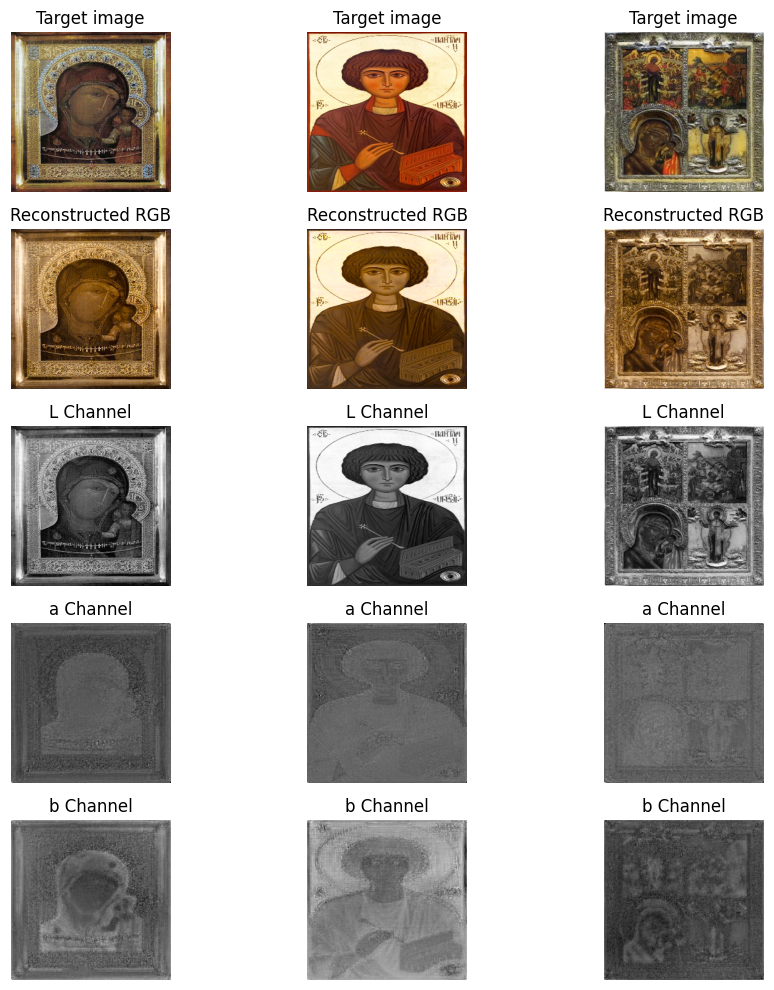

In [ ]:
L_batch = []

for i in val_generator:
    L_batch = i[0]
    break


pred = model.predict(L_batch)
pred = pred

for L_batch, target in val_generator:
    ab_batch = pred
    batch_size = L_batch.shape[0]
    rgb = np.zeros((batch_size, 256, 256, 3))

    ab_batch = ab_batch * 128.0

    for i in range(batch_size):
        L = L_batch[i] * 100.0
        ab = ab_batch[i]  # Already scaled!!!!
        img_lab = np.concatenate([L, ab], axis=-1)
        img_rgb = lab2rgb(img_lab)
        img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
        rgb[i] = img_rgb

    plt.figure(figsize=(10, 10))
    for i in range(3):
        if i >= batch_size:
            break

        # Target color image
        L = L_batch[i] * 100.0
        ab = target[i] * 128.0
        img_lab = np.concatenate([L, ab], axis=-1)
        img_rgb = lab2rgb(img_lab)
        img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
        plt.subplot(5, 3, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title("Target image")

        # Reconstructed color image
        plt.subplot(5, 3, i + 4)
        plt.imshow(rgb[i])
        plt.axis('off')
        plt.title("Reconstructed RGB")

        # Grayscale L channel
        plt.subplot(5, 3, i + 7)
        plt.imshow(L_batch[i].reshape(256, 256), cmap='gray')
        plt.axis('off')
        plt.title("L Channel")

        # a channel
        plt.subplot(5, 3, i + 10)
        plt.imshow(ab_batch[i, :, :, 0], cmap='gray')
        plt.axis('off')
        plt.title("a Channel")

        # b channel
        plt.subplot(5, 3, i + 13)
        plt.imshow(ab_batch[i, :, :, 1], cmap='gray')
        plt.axis('off')
        plt.title("b Channel")

    plt.tight_layout()
    plt.show()
    break  # Only display the first batch
